In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

import pickle
import shap
from catboost import CatBoostClassifier

from IPython.display import display
from ipywidgets import interact_manual
import ipywidgets as widgets

import warnings
warnings.simplefilter("ignore")

In [2]:
shap.initjs()

In [3]:
def get_model(model_name, TIN, split):
    
    # set the path where model is stored
    model_path = f"../results/models/{model_name}_TimeInterval{TIN}_Split{split}"
    
    # load model
    if model_name == "CGB":
        model = CatBoostClassifier()
        model.load_model(model_path)
    elif model_name == "RFC":
        model = pickle.load(open(model_path, 'rb'))
    
    return model

In [4]:
def read_and_preprocess(TIN):
    
    # initial reading
    data = pd.read_csv(f"../data/TimeInterval{TIN}.csv", index_col=0)
    
    # move species from index to the table
    data["species"] = data.index
    
    # create numeric idex
    data.index = range(len(data))
    
    # create categorical feature from Phylum (string)
    data["Phylum_Numeric"] = LabelEncoder().fit_transform(data["Phylum"].tolist())
    
    # remove features we will not use
    data = data.drop(["Phylum", "species", "occurrences", "NoSpecies", 
                      "C_Cnumeric", "SC_Numeric", "MaxD_Numeric", "System_Numeric"], axis=1)
    
    # create features and target dataframes
    features = data.drop(["extinct"], axis=1)
    target = data["extinct"]
    
    # create lists with categorical and continious features' names
    continious_cols = []
    categorical_cols = features.columns.drop(continious_cols).tolist()
    
    # make list of indexes
    categorical_idx = [features.columns.tolist().index(col) for col in categorical_cols]
        
    #return features, target, categorical_idx
    return features

In [5]:
def get_explainer(model_name, TIN, split):
    
    model = get_model(model_name, TIN, split)
    
    features = read_and_preprocess(TIN)
    
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(features)
    
    return explainer, shap_values, features

In [6]:
def explain_single_prediction(prediction_index, model_name, TIN, split):
    
    explainer, shap_values, features = get_explainer(model_name, TIN, split)
    
    if model_name == "CGB":
        print("Warning: predictions are in logarithmic scale")
        display(shap.force_plot(explainer.expected_value,
                                shap_values[prediction_index,:],
                                features.iloc[prediction_index,:]))
    elif model_name == "RFC":
        display(shap.force_plot(explainer.expected_value[1],
                                shap_values[1][prediction_index,:],
                                features.iloc[prediction_index,:]))

In [7]:
explain_single_prediction(413, "CGB", 1, 1)

In [8]:
explain_single_prediction(413, "RFC", 1, 1)

## Widget for interactive investigation of single prediction explanation

In [9]:
interact_manual(explain_single_prediction,
                prediction_index=widgets.IntSlider(min=0, max=500, step=1, value=0),
                model_name=widgets.Dropdown(options=["CGB", "RFC"], value="CGB"),
                TIN=widgets.IntSlider(min=1, max=4, step=1, value=1),
                split=widgets.IntSlider(min=1, max=5, step=1, value=1))

interactive(children=(IntSlider(value=0, description='prediction_index', max=500), Dropdown(description='model…

<function __main__.explain_single_prediction(prediction_index, model_name, TIN, split)>

In [10]:
def explain_all_predictions(model_name, TIN, split):
    
    explainer, shap_values, features = get_explainer(model_name, TIN, split)
    
    if model_name == "CGB":
        print("Warning: predictions are in logarithmic scale")
        display(shap.force_plot(explainer.expected_value,
                                shap_values,
                                features))
        
        display(shap.summary_plot(shap_values, features))
        
    elif model_name == "RFC":
        display(shap.force_plot(explainer.expected_value[1],
                                shap_values[1],
                                features))
        
        display(shap.summary_plot(shap_values[1], features))

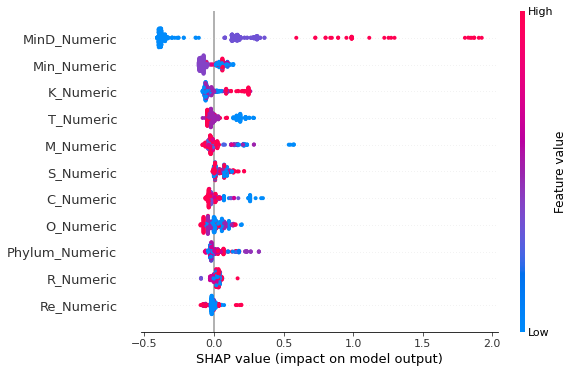

None

In [11]:
explain_all_predictions("CGB", 1, 1)

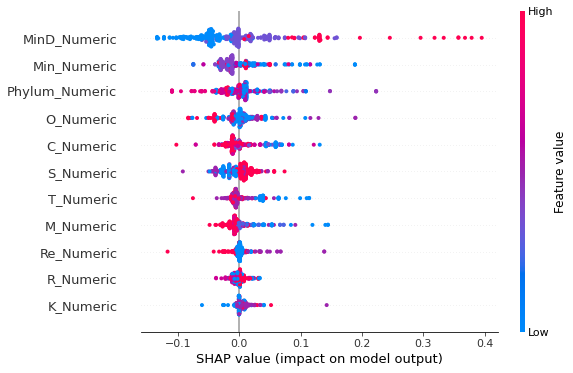

None

In [12]:
explain_all_predictions("RFC", 1, 1)

## Widget for interactive investigation

In [13]:
interact_manual(explain_all_predictions,
                model_name=widgets.Dropdown(options=["CGB", "RFC"], value="CGB"),
                TIN=widgets.IntSlider(min=1, max=4, step=1, value=1),
                split=widgets.IntSlider(min=1, max=5, step=1, value=1))

interactive(children=(Dropdown(description='model_name', options=('CGB', 'RFC'), value='CGB'), IntSlider(value…

<function __main__.explain_all_predictions(model_name, TIN, split)>